### Function Gemma - POC

In [1]:
import os
from dotenv import load_dotenv

load_dotenv()
token = os.getenv("HF_TOKEN")

In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("google/functiongemma-270m-it", device_map="auto", token=token)
model = AutoModelForCausalLM.from_pretrained("google/functiongemma-270m-it", dtype="auto", device_map="auto", token=token)

c:\Users\Maria\Downloads\functiongemma-poc\func-gemma\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#@title Simple POS tool calling dataset
simple_tool_calling = [
  {"user_content":"Passa 50 reais no débito","tool_name":"start_payment","tool_arguments":"{\"amount\": 50, \"payment_method\": \"debito\"}"},
  {"user_content":"Quero cobrar 120 no crédito","tool_name":"start_payment","tool_arguments":"{\"amount\": 120, \"payment_method\": \"credito\"}"},
  {"user_content":"Faz um Pix de 75 reais","tool_name":"start_payment","tool_arguments":"{\"amount\": 75, \"payment_method\": \"pix\"}"},
  {"user_content":"Pode passar 200 reais no crédito","tool_name":"start_payment","tool_arguments":"{\"amount\": 200, \"payment_method\": \"credito\"}"},
  {"user_content":"Cobra 30 reais no débito","tool_name":"start_payment","tool_arguments":"{\"amount\": 30, \"payment_method\": \"debito\"}"},
  {"user_content":"Passa 18 reais no Pix","tool_name":"start_payment","tool_arguments":"{\"amount\": 18, \"payment_method\": \"pix\"}"},
  {"user_content":"Quero fazer uma venda de 500 no crédito","tool_name":"start_payment","tool_arguments":"{\"amount\": 500, \"payment_method\": \"credito\"}"},
  {"user_content":"Passa 99,90 no débito","tool_name":"start_payment","tool_arguments":"{\"amount\": 99.9, \"payment_method\": \"debito\"}"},
  {"user_content":"Cobrar 250 reais no Pix","tool_name":"start_payment","tool_arguments":"{\"amount\": 250, \"payment_method\": \"pix\"}"},
  {"user_content":"Faz uma venda de 60 reais no crédito","tool_name":"start_payment","tool_arguments":"{\"amount\": 60, \"payment_method\": \"credito\"}"},

  {"user_content":"Cancela a última compra","tool_name":"cancel_last_transaction","tool_arguments":"{}"},
  {"user_content":"Cancela essa venda","tool_name":"cancel_last_transaction","tool_arguments":"{}"},
  {"user_content":"Quero cancelar a transação","tool_name":"cancel_last_transaction","tool_arguments":"{}"},
  {"user_content":"Desfaz a última operação","tool_name":"cancel_last_transaction","tool_arguments":"{}"},
  {"user_content":"Cancela o pagamento agora","tool_name":"cancel_last_transaction","tool_arguments":"{}"},

  {"user_content":"Imprime o comprovante do cliente","tool_name":"print_receipt","tool_arguments":"{\"copy_type\": \"cliente\"}"},
  {"user_content":"Quero o comprovante do estabelecimento","tool_name":"print_receipt","tool_arguments":"{\"copy_type\": \"estabelecimento\"}"},
  {"user_content":"Imprime a via do cliente","tool_name":"print_receipt","tool_arguments":"{\"copy_type\": \"cliente\"}"},
  {"user_content":"Mostra o comprovante da loja","tool_name":"print_receipt","tool_arguments":"{\"copy_type\": \"estabelecimento\"}"},
  {"user_content":"Imprime recibo pro cliente","tool_name":"print_receipt","tool_arguments":"{\"copy_type\": \"cliente\"}"},

  {"user_content":"Passa 45 no débito por favor","tool_name":"start_payment","tool_arguments":"{\"amount\": 45, \"payment_method\": \"debito\"}"},
  {"user_content":"Pode cobrar 80 reais no Pix","tool_name":"start_payment","tool_arguments":"{\"amount\": 80, \"payment_method\": \"pix\"}"},
  {"user_content":"Venda de 150 reais no crédito","tool_name":"start_payment","tool_arguments":"{\"amount\": 150, \"payment_method\": \"credito\"}"},
  {"user_content":"Cobrança de 20 reais no débito","tool_name":"start_payment","tool_arguments":"{\"amount\": 20, \"payment_method\": \"debito\"}"},
  {"user_content":"Passa 10 reais no Pix","tool_name":"start_payment","tool_arguments":"{\"amount\": 10, \"payment_method\": \"pix\"}"}
]

In [4]:
from transformers.utils import get_json_schema

def start_payment(amount: float, payment_method: str) -> str:
    """
    Starts a payment on the POS machine.

    Args:
        amount: payment amount
        payment_method: debito, credito or pix
    """
    return "Payment started"


def cancel_last_transaction() -> str:
    """
    Cancels the last transaction.
    """
    return "Last transaction canceled"


def print_receipt(copy_type: str) -> str:
    """
    Prints a receipt.

    Args:
        copy_type: cliente or estabelecimento
    """
    return "Receipt printed"


TOOLS = [
    get_json_schema(start_payment),
    get_json_schema(cancel_last_transaction),
    get_json_schema(print_receipt),
]

In [5]:
import json
from datasets import Dataset
from transformers.utils import get_json_schema


DEFAULT_SYSTEM_MSG = "You are a model that can do function calling with the following functions"

def create_conversation(sample):
  return {
      "messages": [
          {"role": "developer", "content": DEFAULT_SYSTEM_MSG},
          {"role": "user", "content": sample["user_content"]},
          {"role": "assistant", "tool_calls": [{"type": "function", "function": {"name": sample["tool_name"], "arguments": json.loads(sample["tool_arguments"])}}]},
      ],
      "tools": TOOLS
  }

dataset = Dataset.from_list(simple_tool_calling)
# You can also load the dataset from Hugging Face Hub
# dataset = load_dataset("bebechien/SimpleToolCalling", split="train")

# Convert dataset to conversational format
dataset = dataset.map(create_conversation, remove_columns=dataset.features, batched=False)

# Split dataset into 50% training samples and 50% test samples
dataset = dataset.train_test_split(test_size=0.5, shuffle=True)

Map: 100%|██████████| 25/25 [00:00<00:00, 901.85 examples/s]


In [6]:
def check_success_rate():
  success_count = 0
  for idx, item in enumerate(dataset['test']):
    messages = [
        item["messages"][0],
        item["messages"][1],
    ]

    inputs = tokenizer.apply_chat_template(messages, tools=TOOLS, add_generation_prompt=True, return_dict=True, return_tensors="pt")

    out = model.generate(**inputs.to(model.device), pad_token_id=tokenizer.eos_token_id, max_new_tokens=128)
    output = tokenizer.decode(out[0][len(inputs["input_ids"][0]) :], skip_special_tokens=False)

    print(f"{idx+1} Prompt: {item['messages'][1]['content']}")
    print(f"  Output: {output}")

    expected_tool = item['messages'][2]['tool_calls'][0]['function']['name']
    other_tool = "search_knowledge_base" if expected_tool == "search_google" else "search_google"

    if expected_tool in output and other_tool not in output:
      print("  `-> ✅ correct!")
      success_count += 1
    elif expected_tool not in output:
      print(f"  -> ❌ wrong (expected '{expected_tool}' missing)")
    else:
      if output.startswith(f"<start_function_call>call:{expected_tool}"):
        print(f"  -> ⚠️ tool is correct {expected_tool}, but other_tool exists in output")
      else:
        print(f"  -> ❌ wrong (hallucinated '{other_tool}')")

  print(f"Success : {success_count} / {len(dataset['test'])}")

check_success_rate()

1 Prompt: Pode passar 200 reais no crédito
  Output: <start_function_call>call:start_payment{amount:200,payment_method:<escape>credito<escape>}<end_function_call><start_function_response>
  `-> ✅ correct!
2 Prompt: Venda de 150 reais no crédito
  Output: <start_function_call>call:start_payment{amount:150,payment_method:<escape>credito<escape>}<end_function_call><start_function_response>
  `-> ✅ correct!
3 Prompt: Imprime a via do cliente
  Output: I can help with that. To generate the email, could you please specify the customer details you would like to include in the email?<end_of_turn>
  -> ❌ wrong (expected 'print_receipt' missing)
4 Prompt: Quero cancelar a transação
  Output: I can certainly assist with canceling a transaction. To do that, could you please specify the amount you wish to cancel?<end_of_turn>
  -> ❌ wrong (expected 'cancel_last_transaction' missing)
5 Prompt: Passa 10 reais no Pix
  Output: <start_function_call>call:start_payment{amount:1000,payment_method:<escape>

In [7]:
# parameters
checkpoint_dir = f"/content"
learning_rate = 5e-5 #@param {type:"number"}

In [8]:
from trl import SFTConfig
import torch

torch_dtype = model.dtype

args = SFTConfig(
    output_dir=checkpoint_dir,              # directory to save and repository id
    max_length=512,                         # max sequence length for model and packing of the dataset
    packing=False,                          # Groups multiple samples in the dataset into a single sequence
    num_train_epochs=8,                     # number of training epochs
    per_device_train_batch_size=4,          # batch size per device during training
    gradient_checkpointing=False,           # Caching is incompatible with gradient checkpointing
    optim="adamw_torch_fused",              # use fused adamw optimizer
    logging_steps=1,                        # log every step
    #save_strategy="epoch",                  # save checkpoint every epoch
    eval_strategy="epoch",                  # evaluate checkpoint every epoch
    learning_rate=learning_rate,            # learning rate
    fp16=True if torch_dtype == torch.float16 else False,   # use float16 precision
    bf16=True if torch_dtype == torch.bfloat16 else False,  # use bfloat16 precision
    lr_scheduler_type="constant",            # use constant learning rate scheduler
    push_to_hub=True,                        # push model to hub
    report_to="tensorboard",                 # report metrics to tensorboard
)

In [9]:
from trl import SFTTrainer

# Create Trainer object
trainer = SFTTrainer(
    model=model,
    args=args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    processing_class=tokenizer,
)

Truncating eval dataset: 100%|██████████| 13/13 [00:00<00:00, 1101.36 examples/s]
The model is already on multiple devices. Skipping the move to device specified in `args`.


In [10]:
# Start training, the model will be automatically saved to the Hub and the output directory
trainer.train()

# Save the final model again to the Hugging Face Hub
trainer.save_model()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 1, 'bos_token_id': 2, 'pad_token_id': 0}.


Epoch,Training Loss,Validation Loss,Entropy,Num Tokens,Mean Token Accuracy
1,3.107600,1.889023,2.196946,2615.000000,0.667351
2,0.676400,0.417638,0.557180,5230.000000,0.933740
3,0.232000,0.244216,0.215565,7845.000000,0.961790
4,0.130900,0.223085,0.151978,10460.000000,0.971415
5,0.096800,0.226420,0.140655,13075.000000,0.965699
6,0.082300,0.233329,0.112442,15690.000000,0.966814
7,0.075100,0.252454,0.085741,18305.000000,0.965699
8,0.052700,0.276108,0.076456,20920.000000,0.964471


Processing Files (6 / 6): 100%|██████████|  574MB /  574MB,  303MB/s  
New Data Upload: 100%|██████████| 19.0kB / 19.0kB, 11.8kB/s  


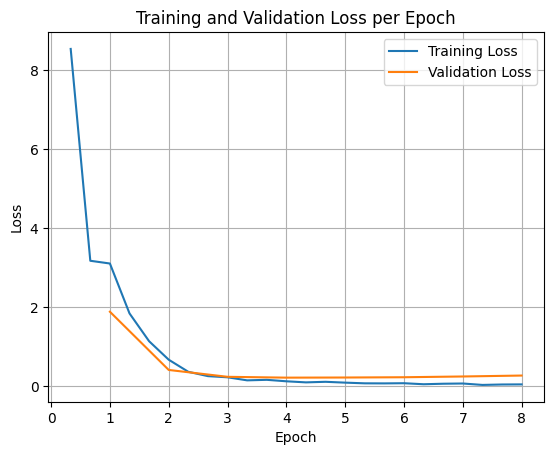

In [11]:
import matplotlib.pyplot as plt

# Access the log history
log_history = trainer.state.log_history

# Extract training / validation loss
train_losses = [log["loss"] for log in log_history if "loss" in log]
epoch_train = [log["epoch"] for log in log_history if "loss" in log]
eval_losses = [log["eval_loss"] for log in log_history if "eval_loss" in log]
epoch_eval = [log["epoch"] for log in log_history if "eval_loss" in log]

# Plot the training loss
plt.plot(epoch_train, train_losses, label="Training Loss")
plt.plot(epoch_eval, eval_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

In [12]:
check_success_rate()

1 Prompt: Pode passar 200 reais no crédito
  Output: <start_function_call>call:start_payment{amount:200.0,payment_method:<escape>credito<escape>}<end_function_call><start_function_response>
  `-> ✅ correct!
2 Prompt: Venda de 150 reais no crédito
  Output: <start_function_call>call:start_payment{amount:150.0,payment_method:<escape>credito<escape>}<end_function_call><start_function_response>
  `-> ✅ correct!
3 Prompt: Imprime a via do cliente
  Output: <start_function_call>call:start_payment{amount:25.0,payment_method:<escape>via<escape>}<end_function_call><start_function_response>
  -> ❌ wrong (expected 'print_receipt' missing)
4 Prompt: Quero cancelar a transação
  Output: <start_function_call>call:cancel_last_transaction{}<end_function_call><start_function_response>
  `-> ✅ correct!
5 Prompt: Passa 10 reais no Pix
  Output: <start_function_call>call:start_payment{amount:10.0,payment_method:<escape>pix<escape>}<end_function_call><start_function_response>
  `-> ✅ correct!
6 Prompt: Pod